CSCI E-82 - Advanced Machine Learning, Data Mining and Artificial Intelligence
=====

# Project - FFNN Classification Notebook

### *Dominic Murphy and David Modjeska*

------

# Introduction

In [1]:
import math
import numpy as np
import pandas as pd
import re

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.decomposition import PCA
from sklearn.metrics import auc, roc_auc_score, roc_curve
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.utils import shuffle

import tensorflow
import keras
from keras.models import Sequential, load_model
from keras.layers import Dense, Activation, Dropout, BatchNormalization, LSTM, regularizers
from keras.optimizers import SGD, Adam
from keras import backend as K
from keras.callbacks import CSVLogger, EarlyStopping, ModelCheckpoint, LearningRateScheduler ,ReduceLROnPlateau
from keras.applications.vgg16 import VGG16, preprocess_input
from keras import metrics
from keras import regularizers

%matplotlib inline
from IPython.display import Image, display, HTML

Using TensorFlow backend.


In [2]:
def my_display(str): 
    display(HTML(str))
    
def my_display_df(df): 
    display(HTML(df.to_html(index=False)))
    
def my_linespace():
    my_display('<p>')
    
plt.rcParams["patch.force_edgecolor"] = True   
plt.style.use('ggplot')

palette = sns.color_palette(palette = 'deep')
sns.set_palette(palette)

# Modeling

*Note: some code has been adapted from https://machinelearningmastery.com/multivariate-time-series-forecasting-lstms-keras/*

#### Helper function to convert a dataframe for supervised learning

In [3]:
def series_to_supervised(data, n_in = 1, n_out = 1, drop_nan = True):
    columns = data.columns.values
    
    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    cols, names = list(), list()
    
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [(columns[j] + '(t-%d)' % (i)) for j in range(n_vars)]
    
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [(columns[j] + '(t)' % ()) for j in range(n_vars)]
        else:
            names += [(columns[j] + '(t+%d)' % (i)) for j in range(n_vars)]
    
    # put it all together
    agg = pd.concat(cols, axis = 1)
    agg.columns = names
    
    # drop rows with NaN values
    if drop_nan:
        agg.dropna(inplace = True)
    
    return agg

#### Load data

In [4]:
data = pd.read_csv('source_data.csv', parse_dates = ['date_key'])
print(data.shape)

(6551, 151)


#### Display first few rows of data

In [5]:
data.head()

,date_dayofyear,date_key,date_month,date_qtr,AU_IS_WORK_DAY,US_IS_WORK_DAY,CA_IS_WORK_DAY,UK_IS_WORK_DAY,IS_EURO,AU_FX,...,UK_FX_MA_090,UK_FX_MA_180,UK_FX_MA_365,temperature,AU_BMP_Ratio,CA_BMP_Ratio,UK_BMP_Ratio,CH_BMP_Ratio,JP_BMP_Ratio,time_index
0,3,2000-01-03,1,1,0,1,1,0,1,0.6591,...,1.628023,1.617005,1.617082,-0.943863,0.680107,0.784969,1.231594,3.715825,1.151735,0
1,4,2000-01-04,1,1,1,1,1,0,1,0.6562,...,1.627812,1.617446,1.617025,-0.940453,0.677115,0.782104,1.239163,3.658705,1.136206,1
2,5,2000-01-05,1,1,1,1,1,1,1,0.6550,...,1.627695,1.617946,1.616983,-0.940453,0.675876,0.782104,1.242570,3.649538,1.128760,2
3,6,2000-01-06,1,1,1,1,1,1,1,0.6540,...,1.627645,1.618471,1.616963,-0.936941,0.674845,0.779259,1.247112,3.652829,1.113523,3
4,7,2000-01-07,1,1,1,1,1,1,1,0.6548,...,1.627491,1.618938,1.616933,-0.936941,0.675670,0.782805,1.240223,3.672339,1.113735,4


#### Extract feature columns

In [6]:
feature_data = data.drop(['date_key', 'time_index'], axis = 1)
feature_cols = feature_data.columns
n_feature_cols = feature_data.shape[1]

## Helper functions

#### Calculate the latest start date among a set of features

In [7]:
euro_start_date = '2000-01-03'

def get_start_row_index(data, col_names):
    return(max([data[col].isnull().idxmin() for col in col_names]))

#### Reduce dimensionality of X by PCA

In [8]:
def pca_X(currency_name, X):
    
    # fit a PCA for exploration only
    n_pcs_total = int(100)
    pca = PCA(n_components = n_pcs_total, svd_solver = 'full', random_state = 0)
    pca.fit(X)
    ratios = np.cumsum(pca.explained_variance_ratio_)
    
    # scree plot of variances explained
    plt.plot(1.0 - ratios)
    plt.title(currency_name + " - PCA cumulative variance explained")
    plt.xlabel("Number of components")
    plt.ylabel("% of variance not explained")
    plt.show()
    
    # computer number of components to use
    n_pcs_to_use = 40
    print('Cumulative variance explained by the first ' + str(n_pcs_to_use) + ' components: ' + 
          str(np.round(ratios[n_pcs_to_use], 4)))
    
    # fit a PCA and transform the data
    pca = PCA(n_components = n_pcs_to_use, svd_solver = 'arpack', random_state = 0)
    pca.fit(X)    
    X_pca = pd.DataFrame(pca.transform(X))
    
    return(X_pca, pca)

#### Helper function to manage data reduction by PCA

In [9]:
def do_pca_X(currency_name, do_pca, n_past_lags, this_data_reframed):
    if do_pca and (n_past_lags > 1):
        X = this_data_reframed.iloc[:, :-1]        
        X_pca, pca = pca_X(currency_name, X)
        this_data_pca = X_pca        
        this_data_pca['y'] = this_data_reframed.iloc[:, -1].values 

        my_display("<h4>Shape of train and test data after PCA</h4>")
        print('Reduced data shape: ' + str(this_data_pca.shape))
    else:
        this_data_pca = this_data_reframed
        pca = None
        
    return(this_data_pca, pca)

#### Helper function to reframe data for supervised training

In [10]:
def reframe_data(this_data_scaled, n_past_lags, n_future_lags, n_these_cols):
    this_data_reframed = series_to_supervised(this_data_scaled, n_past_lags, n_future_lags) # X, y, and extra
    this_data_reframed_past = this_data_reframed.iloc[:, :(n_past_lags*n_these_cols)] # X = past = predictor
    this_data_reframed_future = this_data_reframed.iloc[:, -n_these_cols] # y = future = response
    this_data_reframed = pd.concat([this_data_reframed_past, this_data_reframed_future], axis = 1) # X and y
    
    print('Reframed data shape: ' + str(this_data_reframed.shape))
    return(this_data_reframed)

#### Prepare data for one model

In [11]:
n_past_lags = 180
n_future_lags = 180

def prep_model_data(currency_name, col_names, do_pca = False, verbose = 2):
    my_display("<h3>Prepare model data</h3>")
    
    # extract untransformed data
    n_these_cols = len(col_names)
    start_row_index = get_start_row_index(data, col_names)
    this_data = data[col_names].iloc[start_row_index:, :]
    n_these_rows = this_data.shape[0]
    
    # print data's time period
    print("Time period: " + str(data.date_key.dt.date[0]) + ' - ' + 
          str(data.date_key.dt.date[n_these_rows - 1]))
    
    # list untransformed model features
    if not do_pca:
        my_display("<h4>Features in Model</h4>")
        print(*col_names, sep = ', ')
        print()
    
    # scale data
    scaler = MinMaxScaler(feature_range = (0, 1))
    this_data_scaled = pd.DataFrame(scaler.fit_transform(this_data))
    this_data_scaled.columns = col_names
    print('Scaled data shape: ' + str(this_data_scaled.shape))
    
    # reframe data for supervised training
    this_data_reframed = reframe_data(this_data_scaled, n_past_lags, n_future_lags, n_these_cols)
    
    # convert reframed data for classification
    last_col_name = this_data_reframed.columns[-1]
    this_data_reframed['Is_Up'] = \
        np.where(this_data_reframed.iloc[:, -1] - this_data_reframed.iloc[:, 0] > 0, 1, 0)
    this_data_reframed = this_data_reframed.drop(last_col_name, axis = 1)

    # PCA X (if needed)
    this_data_pca, pca = do_pca_X(currency_name, do_pca, n_past_lags, this_data_reframed)
    
    # display first few rows of supervised data
    if (verbose == 2 and not do_pca):
        my_display("<h4>First few rows of supervised data</h4>")
        my_linespace()
        my_display_df(this_data_pca.head())
        my_linespace()

    # predict y naively as a coin flip
    yhat_naive = pd.DataFrame(np.ones(this_data_pca.shape[0]) * 0.5)
        
    # split into train and test sets
    train, test, yhat_naive_train, yhat_naive_test = \
        train_test_split(this_data_pca, yhat_naive, test_size = 0.33, shuffle = False, random_state = 0)
    
    # split into input and outputs
    train_X, train_y = train.iloc[:, :-1].values, train.iloc[:, -1]
    test_X, test_y = test.iloc[:, :-1].values, test.iloc[:, -1]       
    
#     # reshape input to be 3D [samples, timesteps, features] (LSTM only)
#     train_X = train_X.values.reshape((train_X.shape[0], 1, train_X.shape[1]))
#     test_X = test_X.values.reshape((test_X.shape[0], 1, test_X.shape[1]))
    
    if verbose == 2:
        my_display("<h4>Shape of train and test data</h4>")
        print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)
    
    return(train_X, test_X, train_y, test_y, scaler, pca, yhat_naive_test, n_these_cols)

In [12]:
# adapted from https://github.com/fchollet/keras/issues/5400

def f1(y_true, y_pred):
    
    def recall(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        recall = true_positives / (possible_positives + K.epsilon())
        return recall

    def precision(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision
    
    precision = precision(y_true, y_pred)
    recall = recall(y_true, y_pred)
    
    return 2*((precision*recall)/(precision+recall))

In [13]:
# design network
def define_nn(train_X):
    dropout_ratio = 0.06
    
    model = Sequential()
    
    model.add(Dense(1024, activation='relu', input_shape = [train_X.shape[1]]))
    model.add(Dropout(dropout_ratio))
    model.add(BatchNormalization())          
    
    model.add(Dense(512, activation='relu'))
    model.add(Dropout(dropout_ratio))
    model.add(BatchNormalization())    
    
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(dropout_ratio))
    model.add(BatchNormalization())  
    
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(dropout_ratio))
    model.add(BatchNormalization())  
    
#     model.add(Dense(64, activation='relu'))
#     model.add(Dropout(dropout_ratio))
#     model.add(BatchNormalization())     
    
    model.add(Dense(1, activation = 'sigmoid'))
    
    adam = Adam(lr = 0.01, epsilon = 1e-8)
    model.compile(loss = 'binary_crossentropy', optimizer = adam)
    return(model)

In [14]:
def step_decay(epoch):
    initial_lrate = 0.01
    lrate = initial_lrate / math.pow(epoch + 1, .5)
    return lrate

In [15]:
early_stop = EarlyStopping (monitor = 'val_loss', min_delta = .00001, patience = 50, 
                            verbose = 2, mode = 'auto')

In [16]:
def plot_history(history):
    print()
    fig = plt.figure(figsize = (8, 6))
    plt.plot(history.history['loss'], label = 'train')
    plt.plot(history.history['val_loss'], label = 'test')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training History')
    plt.legend()
    plt.show()   

#### Helper function to instantiate and fit one model, and plot the feature importances

In [17]:
def define_fit_model(currency_name, train_X, test_X, train_y, test_y, do_pca = False, verbose = 2):
    my_display("<h3>Fit model</h3>") 
    
    n_epochs = 200    
    reduce_lr = LearningRateScheduler(step_decay)
    model_checkpoint = ModelCheckpoint(filepath = "./best_model.hdf5", monitor = 'val_loss', 
                                       verbose = 2, save_best_only = True, 
                                       save_weights_only = True, mode = 'auto', period = 1)
   
    # fit model
    model = define_nn(train_X)    
    history = model.fit(train_X, train_y, epochs = n_epochs, batch_size = 32, 
                        validation_data = (test_X, test_y), verbose = verbose, shuffle = False,
                       callbacks = [reduce_lr, model_checkpoint, early_stop])
    
    # plot training history
    if verbose == 2:       
        plot_history(history)
        
    return(model)

#### Helper function to inverse transform the data

In [18]:
def inverse_transform(y, X, scaler, pca, n_cols):
    if pca is not None:
        X = pca.inverse_transform(X)
    else:
        X = X.values
        
    inv_y = np.concatenate((y, X[:, 1:n_cols]), axis = 1)
    inv_y = scaler.inverse_transform(inv_y)
    inv_y = inv_y[:, 0]
    
    return(inv_y)

#### Helper function to plot ROC AUC curve

In [19]:
# adapted from http://scikit-learn.org/stable/auto_examples/model_selection/plot_roc.html
def display_roc_curve(y, predict_y_proba):
   
    fp_rate1, tp_rate1, _ = roc_curve(y, predict_y_proba)
    roc_auc1 = auc(fp_rate1, tp_rate1)

    print()
    plt.figure(figsize = (4.5, 4.5))
    plt.title('ROC Curve (Class = 1)')
    
    plt.plot(fp_rate1, tp_rate1, 'b',
    label='AUC = %0.3f'% roc_auc1)
    plt.legend(loc='lower right')
    
    plt.plot([0,1],[0,1],'r--', lw = 1)
    plt.xlim([-0.1, 1.2])
    plt.ylim([-0.1, 1.2])
    
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    
    plt.show()

#### Score a model with test data

In [20]:
no_score = None

def score_model(currency_name, best_model, train_X, test_X, train_y, test_y, scaler, pca, 
                inv_yhat_naive, n_cols, verbose = 2):
    my_display("<h3>Score model on test data</h3>")
    
    # reload best model (LSTM only)
    best_model = define_nn(train_X)
    best_model.load_weights('./best_model.hdf5')
    
    # make a prediction on test data
    this_X = test_X
    yhat = best_model.predict_proba(this_X).reshape(-1, 1)
    #test_X = test_X.reshape((test_X.shape[0], test_X.shape[2]))

    # invert/reverse/undo scaling for forecast
    inv_yhat = yhat
    
    # invert scaling for actual
    test_y = test_y.values.reshape((len(test_y), 1))
    inv_y = test_y
    
    # invert scaling for y-hat naive
    inv_yhat_naive = inv_yhat_naive.values.reshape((len(inv_yhat_naive), 1))     
    
    # naive model
    my_display("<h4>AUC from naive model that flips a coin</h4>")
    naive_score = roc_auc_score(inv_y, inv_yhat_naive)
    print("AUC: " + str(np.round(naive_score, 5)))
    
    # calculate RMSE on test data
    my_display("<h4>AUC from fitted model</h4>")
    test_score = roc_auc_score(inv_y, inv_yhat)
    print("AUC: " + str(np.round(test_score, 5)))
    
    if verbose == 2 and pca is None:
        display_roc_curve(inv_y, inv_yhat)
    
    return(naive_score, test_score)

#### Top-level function to create, fit, and score one model

In [21]:
def do_one_model(currency_name, feature_col_names, do_pca = False, verbose = 2):
    if do_pca:
        return(0.5, None)
    
    train_X, test_X, train_y, test_y, scaler, pca, yhat_naive_test, n_features = \
        prep_model_data(currency_name, feature_col_names, do_pca, verbose)
    best_model = define_fit_model(currency_name, train_X, test_X, train_y, test_y, do_pca, verbose)
    naive_score, test_score = score_model(currency_name, best_model, train_X, test_X, train_y, test_y,
                                          scaler, pca, 
                                        yhat_naive_test, n_features, verbose = verbose)
    
    return(naive_score, test_score)

#### Create a dataframe to accumulate modeling results for all currencies

In [22]:
all_results = pd.DataFrame()

#### Accumulate results from one model

In [23]:
def accum_results(all_results, currency, naive_score, fx_auc, fx_features_auc, fx_all_auc):
    results = pd.DataFrame({'Currency': currency, 
                              'Naive': naive_score, 
                              'FX Only': fx_auc, 
                              'FX + Features': fx_features_auc,
                              'All Features': fx_all_auc},
                            index = range(1))
    all_results = all_results.append(results).reset_index(drop = True)
    return(all_results)

## Australia

### FX rates only

Time period: 2000-01-03 - 2017-12-09


AU_FX

Scaled data shape: (6551, 1)
Reframed data shape: (6192, 181)


AU_FX(t-180),AU_FX(t-179),AU_FX(t-178),AU_FX(t-177),AU_FX(t-176),AU_FX(t-175),AU_FX(t-174),AU_FX(t-173),AU_FX(t-172),AU_FX(t-171),AU_FX(t-170),AU_FX(t-169),AU_FX(t-168),AU_FX(t-167),AU_FX(t-166),AU_FX(t-165),AU_FX(t-164),AU_FX(t-163),AU_FX(t-162),AU_FX(t-161),AU_FX(t-160),AU_FX(t-159),AU_FX(t-158),AU_FX(t-157),AU_FX(t-156),AU_FX(t-155),AU_FX(t-154),AU_FX(t-153),AU_FX(t-152),AU_FX(t-151),AU_FX(t-150),AU_FX(t-149),AU_FX(t-148),AU_FX(t-147),AU_FX(t-146),AU_FX(t-145),AU_FX(t-144),AU_FX(t-143),AU_FX(t-142),AU_FX(t-141),AU_FX(t-140),AU_FX(t-139),AU_FX(t-138),AU_FX(t-137),AU_FX(t-136),AU_FX(t-135),AU_FX(t-134),AU_FX(t-133),AU_FX(t-132),AU_FX(t-131),AU_FX(t-130),AU_FX(t-129),AU_FX(t-128),AU_FX(t-127),AU_FX(t-126),AU_FX(t-125),AU_FX(t-124),AU_FX(t-123),AU_FX(t-122),AU_FX(t-121),AU_FX(t-120),AU_FX(t-119),AU_FX(t-118),AU_FX(t-117),AU_FX(t-116),AU_FX(t-115),AU_FX(t-114),AU_FX(t-113),AU_FX(t-112),AU_FX(t-111),AU_FX(t-110),AU_FX(t-109),AU_FX(t-108),AU_FX(t-107),AU_FX(t-106),AU_FX(t-105),AU_FX(t-104),AU_FX(t-103),AU_FX(t-102),AU_FX(t-101),AU_FX(t-100),AU_FX(t-99),AU_FX(t-98),AU_FX(t-97),AU_FX(t-96),AU_FX(t-95),AU_FX(t-94),AU_FX(t-93),AU_FX(t-92),AU_FX(t-91),AU_FX(t-90),AU_FX(t-89),AU_FX(t-88),AU_FX(t-87),AU_FX(t-86),AU_FX(t-85),AU_FX(t-84),AU_FX(t-83),AU_FX(t-82),AU_FX(t-81),AU_FX(t-80),AU_FX(t-79),AU_FX(t-78),AU_FX(t-77),AU_FX(t-76),AU_FX(t-75),AU_FX(t-74),AU_FX(t-73),AU_FX(t-72),AU_FX(t-71),AU_FX(t-70),AU_FX(t-69),AU_FX(t-68),AU_FX(t-67),AU_FX(t-66),AU_FX(t-65),AU_FX(t-64),AU_FX(t-63),AU_FX(t-62),AU_FX(t-61),AU_FX(t-60),AU_FX(t-59),AU_FX(t-58),AU_FX(t-57),AU_FX(t-56),AU_FX(t-55),AU_FX(t-54),AU_FX(t-53),AU_FX(t-52),AU_FX(t-51),AU_FX(t-50),AU_FX(t-49),AU_FX(t-48),AU_FX(t-47),AU_FX(t-46),AU_FX(t-45),AU_FX(t-44),AU_FX(t-43),AU_FX(t-42),AU_FX(t-41),AU_FX(t-40),AU_FX(t-39),AU_FX(t-38),AU_FX(t-37),AU_FX(t-36),AU_FX(t-35),AU_FX(t-34),AU_FX(t-33),AU_FX(t-32),AU_FX(t-31),AU_FX(t-30),AU_FX(t-29),AU_FX(t-28),AU_FX(t-27),AU_FX(t-26),AU_FX(t-25),AU_FX(t-24),AU_FX(t-23),AU_FX(t-22),AU_FX(t-21),AU_FX(t-20),AU_FX(t-19),AU_FX(t-18),AU_FX(t-17),AU_FX(t-16),AU_FX(t-15),AU_FX(t-14),AU_FX(t-13),AU_FX(t-12),AU_FX(t-11),AU_FX(t-10),AU_FX(t-9),AU_FX(t-8),AU_FX(t-7),AU_FX(t-6),AU_FX(t-5),AU_FX(t-4),AU_FX(t-3),AU_FX(t-2),AU_FX(t-1),Is_Up
0.284447,0.279768,0.277832,0.276218,0.277509,0.278208,0.278907,0.279606,0.281865,0.282349,0.299935,0.296386,0.295714,0.295041,0.294369,0.292352,0.291384,0.296547,0.289287,0.285146,0.281005,0.276864,0.276541,0.270571,0.277832,0.231849,0.238141,0.244434,0.250726,0.239916,0.247177,0.251533,0.239916,0.241207,0.242498,0.243788,0.246047,0.244756,0.240723,0.234592,0.234430,0.234269,0.234108,0.237496,0.237657,0.240723,0.236205,0.235264,0.234323,0.233382,0.230558,0.220716,0.212327,0.217328,0.214155,0.210982,0.207809,0.214101,0.199903,0.201517,0.202323,0.198774,0.195224,0.191675,0.194740,0.204259,0.214101,0.211036,0.212595,0.214155,0.215715,0.211681,0.209261,0.206357,0.199903,0.199796,0.199688,0.199581,0.205227,0.198128,0.195708,0.199419,0.202108,0.204797,0.207486,0.211843,0.209100,0.209261,0.199096,0.199688,0.200280,0.200871,0.194256,0.197644,0.191675,0.189577,0.188932,0.188287,0.187641,0.182156,0.184253,0.183124,0.184576,0.181403,0.178230,0.175056,0.180381,0.182156,0.177961,0.176993,0.178068,0.179144,0.180219,0.181994,0.171346,0.168925,0.162794,0.160805,0.158815,0.156825,0.166021,0.172959,0.175218,0.178606,0.175110,0.171614,0.168119,0.161342,0.159245,0.155211,0.158438,0.154620,0.150801,0.146983,0.152469,0.138270,0.141175,0.145208,0.145854,0.146499,0.147144,0.148274,0.142788,0.140691,0.143272,0.144670,0.146069,0.147467,0.151662,0.141981,0.144079,0.155211,0.156395,0.157578,0.158761,0.170862,0.172959,0.169409,0.167151,0.169732,0.172314,0.174895,0.184737,0.190223,0.191513,0.202485,0.199312,0.196139,0.192965,0.195063,0.193288,0.187964,0.183285,0.183339,0.183392,0.183446,0.191029,0.192804,0.193772,0.184414,0
0.279768,0.277832,0.276218,0.277509,0.278208,0.278907,0.279606,0.281865,0.282349,0.299935,0.296386,0.295714,0.295041,0.294369,0.292352,0.291

(4148, 180) (4148,) (2044, 180) (2044,)


Train on 4148 samples, validate on 2044 samples
Epoch 1/200
3s - loss: 0.7685 - val_loss: 7.5486
Epoch 2/200
3s - loss: 0.6785 - val_loss: 2.1060
Epoch 3/200
3s - loss: 0.6542 - val_loss: 1.8439
Epoch 4/200
3s - loss: 0.6445 - val_loss: 1.6493
Epoch 5/200
3s - loss: 0.6380 - val_loss: 0.7109
Epoch 6/200
3s - loss: 0.6341 - val_loss: 0.6898
Epoch 7/200
3s - loss: 0.6268 - val_loss: 1.5513
Epoch 8/200
3s - loss: 0.6227 - val_loss: 1.0952
Epoch 9/200
3s - loss: 0.6207 - val_loss: 0.8179
Epoch 10/200
3s - loss: 0.6181 - val_loss: 0.7384
Epoch 11/200
3s - loss: 0.6160 - val_loss: 0.8621
Epoch 12/200
3s - loss: 0.6146 - val_loss: 0.8187
Epoch 13/200
3s - loss: 0.6128 - val_loss: 0.8317
Epoch 14/200
3s - loss: 0.6125 - val_loss: 0.9545
Epoch 15/200
3s - loss: 0.6113 - val_loss: 0.8332
Epoch 16/200
3s - loss: 0.6106 - val_loss: 0.8370
Epoch 17/200
3s - loss: 0.6100 - val_loss: 0.7302
Epoch 18/200
3s - loss: 0.6092 - val_loss: 1.4392
Epoch 19/200
3s - loss: 0.6083 - val_loss: 1.1946
Epoch 20/20

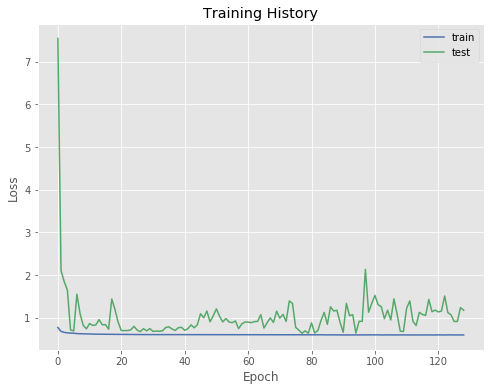

1984/2044 [============================>.] - ETA: 0s

AUC: 0.5


AUC: 0.77536



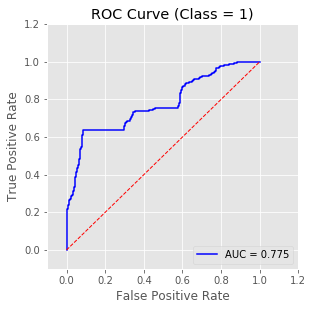

In [24]:
naive_score, fx_auc = do_one_model('AUD', feature_col_names = ['AU_FX'], verbose = 2)

### FX rates and other features

Time period: 2000-01-03 - 2017-12-09


AU_FX, AU_BMP_Ratio

Scaled data shape: (6551, 2)
Reframed data shape: (6192, 361)


AU_FX(t-180),AU_BMP_Ratio(t-180),AU_FX(t-179),AU_BMP_Ratio(t-179),AU_FX(t-178),AU_BMP_Ratio(t-178),AU_FX(t-177),AU_BMP_Ratio(t-177),AU_FX(t-176),AU_BMP_Ratio(t-176),AU_FX(t-175),AU_BMP_Ratio(t-175),AU_FX(t-174),AU_BMP_Ratio(t-174),AU_FX(t-173),AU_BMP_Ratio(t-173),AU_FX(t-172),AU_BMP_Ratio(t-172),AU_FX(t-171),AU_BMP_Ratio(t-171),AU_FX(t-170),AU_BMP_Ratio(t-170),AU_FX(t-169),AU_BMP_Ratio(t-169),AU_FX(t-168),AU_BMP_Ratio(t-168),AU_FX(t-167),AU_BMP_Ratio(t-167),AU_FX(t-166),AU_BMP_Ratio(t-166),AU_FX(t-165),AU_BMP_Ratio(t-165),AU_FX(t-164),AU_BMP_Ratio(t-164),AU_FX(t-163),AU_BMP_Ratio(t-163),AU_FX(t-162),AU_BMP_Ratio(t-162),AU_FX(t-161),AU_BMP_Ratio(t-161),AU_FX(t-160),AU_BMP_Ratio(t-160),AU_FX(t-159),AU_BMP_Ratio(t-159),AU_FX(t-158),AU_BMP_Ratio(t-158),AU_FX(t-157),AU_BMP_Ratio(t-157),AU_FX(t-156),AU_BMP_Ratio(t-156),AU_FX(t-155),AU_BMP_Ratio(t-155),AU_FX(t-154),AU_BMP_Ratio(t-154),AU_FX(t-153),AU_BMP_Ratio(t-153),AU_FX(t-152),AU_BMP_Ratio(t-152),AU_FX(t-151),AU_BMP_Ratio(t-151),AU_FX(t-150),AU_BMP_Ratio(t-150),AU_FX(t-149),AU_BMP_Ratio(t-149),AU_FX(t-148),AU_BMP_Ratio(t-148),AU_FX(t-147),AU_BMP_Ratio(t-147),AU_FX(t-146),AU_BMP_Ratio(t-146),AU_FX(t-145),AU_BMP_Ratio(t-145),AU_FX(t-144),AU_BMP_Ratio(t-144),AU_FX(t-143),AU_BMP_Ratio(t-143),AU_FX(t-142),AU_BMP_Ratio(t-142),AU_FX(t-141),AU_BMP_Ratio(t-141),AU_FX(t-140),AU_BMP_Ratio(t-140),AU_FX(t-139),AU_BMP_Ratio(t-139),AU_FX(t-138),AU_BMP_Ratio(t-138),AU_FX(t-137),AU_BMP_Ratio(t-137),AU_FX(t-136),AU_BMP_Ratio(t-136),AU_FX(t-135),AU_BMP_Ratio(t-135),AU_FX(t-134),AU_BMP_Ratio(t-134),AU_FX(t-133),AU_BMP_Ratio(t-133),AU_FX(t-132),AU_BMP_Ratio(t-132),AU_FX(t-131),AU_BMP_Ratio(t-131),AU_FX(t-130),AU_BMP_Ratio(t-130),AU_FX(t-129),AU_BMP_Ratio(t-129),AU_FX(t-128),AU_BMP_Ratio(t-128),AU_FX(t-127),AU_BMP_Ratio(t-127),AU_FX(t-126),AU_BMP_Ratio(t-126),AU_FX(t-125),AU_BMP_Ratio(t-125),AU_FX(t-124),AU_BMP_Ratio(t-124),AU_FX(t-123),AU_BMP_Ratio(t-123),AU_FX(t-122),AU_BMP_Ratio(t-122),AU_FX(t-121),AU_BMP_Ratio(t-121),AU_FX(t-120),AU_BMP_Ratio(t-120),AU_FX(t-119),AU_BMP_Ratio(t-119),AU_FX(t-118),AU_BMP_Ratio(t-118),AU_FX(t-117),AU_BMP_Ratio(t-117),AU_FX(t-116),AU_BMP_Ratio(t-116),AU_FX(t-115),AU_BMP_Ratio(t-115),AU_FX(t-114),AU_BMP_Ratio(t-114),AU_FX(t-113),AU_BMP_Ratio(t-113),AU_FX(t-112),AU_BMP_Ratio(t-112),AU_FX(t-111),AU_BMP_Ratio(t-111),AU_FX(t-110),AU_BMP_Ratio(t-110),AU_FX(t-109),AU_BMP_Ratio(t-109),AU_FX(t-108),AU_BMP_Ratio(t-108),AU_FX(t-107),AU_BMP_Ratio(t-107),AU_FX(t-106),AU_BMP_Ratio(t-106),AU_FX(t-105),AU_BMP_Ratio(t-105),AU_FX(t-104),AU_BMP_Ratio(t-104),AU_FX(t-103),AU_BMP_Ratio(t-103),AU_FX(t-102),AU_BMP_Ratio(t-102),AU_FX(t-101),AU_BMP_Ratio(t-101),AU_FX(t-100),AU_BMP_Ratio(t-100),AU_FX(t-99),AU_BMP_Ratio(t-99),AU_FX(t-98),AU_BMP_Ratio(t-98),AU_FX(t-97),AU_BMP_Ratio(t-97),AU_FX(t-96),AU_BMP_Ratio(t-96),AU_FX(t-95),AU_BMP_Ratio(t-95),AU_FX(t-94),AU_BMP_Ratio(t-94),AU_FX(t-93),AU_BMP_Ratio(t-93),AU_FX(t-92),AU_BMP_Ratio(t-92),AU_FX(t-91),AU_BMP_Ratio(t-91),AU_FX(t-90),AU_BMP_Ratio(t-90),AU_FX(t-89),AU_BMP_Ratio(t-89),AU_FX(t-88),AU_BMP_Ratio(t-88),AU_FX(t-87),AU_BMP_Ratio(t-87),AU_FX(t-86),AU_BMP_Ratio(t-86),AU_FX(t-85),AU_BMP_Ratio(t-85),AU_FX(t-84),AU_BMP_Ratio(t-84),AU_FX(t-83),AU_BMP_Ratio(t-83),AU_FX(t-82),AU_BMP_Ratio(t-82),AU_FX(t-81),AU_BMP_Ratio(t-81),AU_FX(t-80),AU_BMP_Ratio(t-80),AU_FX(t-79),AU_BMP_Ratio(t-79),AU_FX(t-78),AU_BMP_Ratio(t-78),AU_FX(t-77),AU_BMP_Ratio(t-77),AU_FX(t-76),AU_BMP_Ratio(t-76),AU_FX(t-75),AU_BMP_Ratio(t-75),AU_FX(t-74),AU_BMP_Ratio(t-74),AU_FX(t-73),AU_BMP_Ratio(t-73),AU_FX(t-72),AU_BMP_Ratio(t-72),AU_FX(t-71),AU_BMP_Ratio(t-71),AU_FX(t-70),AU_BMP_Ratio(t-70),AU_FX(t-69),AU_BMP_Ratio(t-69),AU_FX(t-68),AU_BMP_Ratio(t-68),AU_FX(t-67),AU_BMP_Ratio(t-67),AU_FX(t-66),AU_BMP_Ratio(t-66),AU_FX(t-65),AU_BMP_Ratio(t-65),AU_FX(t-64),AU_BMP_Ratio(t-64),AU_FX(t-63),AU_BMP_Ratio(t-63),AU_FX(t-62),AU_BMP_Ratio(t-62),AU_FX(t-61),AU_BMP_Ratio(t-61),AU_FX(t-60),AU_BMP_Ratio(t-60),AU_FX(t-59),AU_BMP_Ratio(t-59),AU_FX(t-58),AU_BMP_Ratio(t-58),AU_FX(t-57),AU_BMP_Ratio(

(4148, 360) (4148,) (2044, 360) (2044,)


Train on 4148 samples, validate on 2044 samples
Epoch 1/200
3s - loss: 0.7599 - val_loss: 8.5698
Epoch 2/200
3s - loss: 0.6876 - val_loss: 4.3357
Epoch 3/200
4s - loss: 0.6536 - val_loss: 4.1169
Epoch 4/200
3s - loss: 0.6436 - val_loss: 1.6588
Epoch 5/200
3s - loss: 0.6368 - val_loss: 1.4339
Epoch 6/200
3s - loss: 0.6302 - val_loss: 1.3208
Epoch 7/200
3s - loss: 0.6260 - val_loss: 0.9769
Epoch 8/200
3s - loss: 0.6220 - val_loss: 1.5638
Epoch 9/200
3s - loss: 0.6190 - val_loss: 0.9882
Epoch 10/200
3s - loss: 0.6177 - val_loss: 0.8472
Epoch 11/200
3s - loss: 0.6154 - val_loss: 1.1943
Epoch 12/200
3s - loss: 0.6137 - val_loss: 0.8745
Epoch 13/200
3s - loss: 0.6128 - val_loss: 1.8084
Epoch 14/200
3s - loss: 0.6109 - val_loss: 1.0934
Epoch 15/200
3s - loss: 0.6094 - val_loss: 1.2323
Epoch 16/200
3s - loss: 0.6095 - val_loss: 1.1519
Epoch 17/200
3s - loss: 0.6088 - val_loss: 0.8932
Epoch 18/200
3s - loss: 0.6076 - val_loss: 0.7603
Epoch 19/200
3s - loss: 0.6073 - val_loss: 0.8014
Epoch 20/20

3s - loss: 0.5858 - val_loss: 0.7196
Epoch 164/200
3s - loss: 0.5847 - val_loss: 0.9438
Epoch 165/200
3s - loss: 0.5857 - val_loss: 0.6534
Epoch 166/200
3s - loss: 0.5847 - val_loss: 0.7009
Epoch 167/200
3s - loss: 0.5843 - val_loss: 0.7750
Epoch 168/200
3s - loss: 0.5845 - val_loss: 0.7853
Epoch 169/200
3s - loss: 0.5842 - val_loss: 0.6516
Epoch 170/200
3s - loss: 0.5848 - val_loss: 0.7772
Epoch 171/200
3s - loss: 0.5861 - val_loss: 0.9098
Epoch 172/200
3s - loss: 0.5864 - val_loss: 0.5739
Epoch 173/200
3s - loss: 0.5864 - val_loss: 0.8688
Epoch 174/200
3s - loss: 0.5838 - val_loss: 0.7646
Epoch 175/200
3s - loss: 0.5844 - val_loss: 0.6095
Epoch 176/200
3s - loss: 0.5877 - val_loss: 0.7067
Epoch 177/200
3s - loss: 0.5855 - val_loss: 0.6749
Epoch 178/200
3s - loss: 0.5870 - val_loss: 0.7703
Epoch 179/200
3s - loss: 0.5888 - val_loss: 0.9308
Epoch 180/200
3s - loss: 0.5847 - val_loss: 0.9573
Epoch 181/200
3s - loss: 0.5884 - val_loss: 0.9084
Epoch 182/200
3s - loss: 0.5854 - val_loss: 0

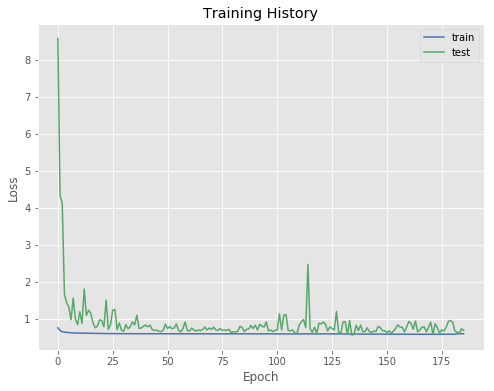

2016/2044 [============================>.] - ETA: 0s

AUC: 0.5


AUC: 0.75786



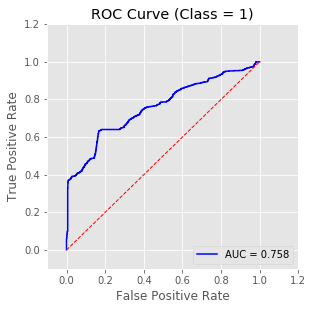

In [25]:
naive_score, fx_features_auc = do_one_model('AUD', feature_col_names = ['AU_FX', 'AU_BMP_Ratio'])

### All features

In [26]:
cols = [feature_cols[i] for i in range(n_feature_cols) 
        if re.search('AU_FX', feature_cols[i]) == None]
naive_score, fx_all_auc = do_one_model('AUD', feature_col_names = ['AU_FX'] + cols, do_pca = True)

In [27]:
all_results = accum_results(all_results, 'AUD', naive_score, fx_auc, fx_features_auc, fx_all_auc)

## Canada

### FX rates only

In [28]:
naive_score, fx_auc = do_one_model('CAD', feature_col_names = ['CA_FX'], verbose = 2)

Time period: 2000-01-03 - 2017-12-09


CA_FX

Scaled data shape: (6551, 1)
Reframed data shape: (6192, 181)


2016/2044 [============================>.] - ETA: 0s

AUC: 0.5


AUC: 0.43917


### FX rates and other features

Time period: 2000-01-03 - 2017-12-09


CA_FX, CA_BMP_Ratio

Scaled data shape: (6551, 2)
Reframed data shape: (6192, 361)


CA_FX(t-180),CA_BMP_Ratio(t-180),CA_FX(t-179),CA_BMP_Ratio(t-179),CA_FX(t-178),CA_BMP_Ratio(t-178),CA_FX(t-177),CA_BMP_Ratio(t-177),CA_FX(t-176),CA_BMP_Ratio(t-176),CA_FX(t-175),CA_BMP_Ratio(t-175),CA_FX(t-174),CA_BMP_Ratio(t-174),CA_FX(t-173),CA_BMP_Ratio(t-173),CA_FX(t-172),CA_BMP_Ratio(t-172),CA_FX(t-171),CA_BMP_Ratio(t-171),CA_FX(t-170),CA_BMP_Ratio(t-170),CA_FX(t-169),CA_BMP_Ratio(t-169),CA_FX(t-168),CA_BMP_Ratio(t-168),CA_FX(t-167),CA_BMP_Ratio(t-167),CA_FX(t-166),CA_BMP_Ratio(t-166),CA_FX(t-165),CA_BMP_Ratio(t-165),CA_FX(t-164),CA_BMP_Ratio(t-164),CA_FX(t-163),CA_BMP_Ratio(t-163),CA_FX(t-162),CA_BMP_Ratio(t-162),CA_FX(t-161),CA_BMP_Ratio(t-161),CA_FX(t-160),CA_BMP_Ratio(t-160),CA_FX(t-159),CA_BMP_Ratio(t-159),CA_FX(t-158),CA_BMP_Ratio(t-158),CA_FX(t-157),CA_BMP_Ratio(t-157),CA_FX(t-156),CA_BMP_Ratio(t-156),CA_FX(t-155),CA_BMP_Ratio(t-155),CA_FX(t-154),CA_BMP_Ratio(t-154),CA_FX(t-153),CA_BMP_Ratio(t-153),CA_FX(t-152),CA_BMP_Ratio(t-152),CA_FX(t-151),CA_BMP_Ratio(t-151),CA_FX(t-150),CA_BMP_Ratio(t-150),CA_FX(t-149),CA_BMP_Ratio(t-149),CA_FX(t-148),CA_BMP_Ratio(t-148),CA_FX(t-147),CA_BMP_Ratio(t-147),CA_FX(t-146),CA_BMP_Ratio(t-146),CA_FX(t-145),CA_BMP_Ratio(t-145),CA_FX(t-144),CA_BMP_Ratio(t-144),CA_FX(t-143),CA_BMP_Ratio(t-143),CA_FX(t-142),CA_BMP_Ratio(t-142),CA_FX(t-141),CA_BMP_Ratio(t-141),CA_FX(t-140),CA_BMP_Ratio(t-140),CA_FX(t-139),CA_BMP_Ratio(t-139),CA_FX(t-138),CA_BMP_Ratio(t-138),CA_FX(t-137),CA_BMP_Ratio(t-137),CA_FX(t-136),CA_BMP_Ratio(t-136),CA_FX(t-135),CA_BMP_Ratio(t-135),CA_FX(t-134),CA_BMP_Ratio(t-134),CA_FX(t-133),CA_BMP_Ratio(t-133),CA_FX(t-132),CA_BMP_Ratio(t-132),CA_FX(t-131),CA_BMP_Ratio(t-131),CA_FX(t-130),CA_BMP_Ratio(t-130),CA_FX(t-129),CA_BMP_Ratio(t-129),CA_FX(t-128),CA_BMP_Ratio(t-128),CA_FX(t-127),CA_BMP_Ratio(t-127),CA_FX(t-126),CA_BMP_Ratio(t-126),CA_FX(t-125),CA_BMP_Ratio(t-125),CA_FX(t-124),CA_BMP_Ratio(t-124),CA_FX(t-123),CA_BMP_Ratio(t-123),CA_FX(t-122),CA_BMP_Ratio(t-122),CA_FX(t-121),CA_BMP_Ratio(t-121),CA_FX(t-120),CA_BMP_Ratio(t-120),CA_FX(t-119),CA_BMP_Ratio(t-119),CA_FX(t-118),CA_BMP_Ratio(t-118),CA_FX(t-117),CA_BMP_Ratio(t-117),CA_FX(t-116),CA_BMP_Ratio(t-116),CA_FX(t-115),CA_BMP_Ratio(t-115),CA_FX(t-114),CA_BMP_Ratio(t-114),CA_FX(t-113),CA_BMP_Ratio(t-113),CA_FX(t-112),CA_BMP_Ratio(t-112),CA_FX(t-111),CA_BMP_Ratio(t-111),CA_FX(t-110),CA_BMP_Ratio(t-110),CA_FX(t-109),CA_BMP_Ratio(t-109),CA_FX(t-108),CA_BMP_Ratio(t-108),CA_FX(t-107),CA_BMP_Ratio(t-107),CA_FX(t-106),CA_BMP_Ratio(t-106),CA_FX(t-105),CA_BMP_Ratio(t-105),CA_FX(t-104),CA_BMP_Ratio(t-104),CA_FX(t-103),CA_BMP_Ratio(t-103),CA_FX(t-102),CA_BMP_Ratio(t-102),CA_FX(t-101),CA_BMP_Ratio(t-101),CA_FX(t-100),CA_BMP_Ratio(t-100),CA_FX(t-99),CA_BMP_Ratio(t-99),CA_FX(t-98),CA_BMP_Ratio(t-98),CA_FX(t-97),CA_BMP_Ratio(t-97),CA_FX(t-96),CA_BMP_Ratio(t-96),CA_FX(t-95),CA_BMP_Ratio(t-95),CA_FX(t-94),CA_BMP_Ratio(t-94),CA_FX(t-93),CA_BMP_Ratio(t-93),CA_FX(t-92),CA_BMP_Ratio(t-92),CA_FX(t-91),CA_BMP_Ratio(t-91),CA_FX(t-90),CA_BMP_Ratio(t-90),CA_FX(t-89),CA_BMP_Ratio(t-89),CA_FX(t-88),CA_BMP_Ratio(t-88),CA_FX(t-87),CA_BMP_Ratio(t-87),CA_FX(t-86),CA_BMP_Ratio(t-86),CA_FX(t-85),CA_BMP_Ratio(t-85),CA_FX(t-84),CA_BMP_Ratio(t-84),CA_FX(t-83),CA_BMP_Ratio(t-83),CA_FX(t-82),CA_BMP_Ratio(t-82),CA_FX(t-81),CA_BMP_Ratio(t-81),CA_FX(t-80),CA_BMP_Ratio(t-80),CA_FX(t-79),CA_BMP_Ratio(t-79),CA_FX(t-78),CA_BMP_Ratio(t-78),CA_FX(t-77),CA_BMP_Ratio(t-77),CA_FX(t-76),CA_BMP_Ratio(t-76),CA_FX(t-75),CA_BMP_Ratio(t-75),CA_FX(t-74),CA_BMP_Ratio(t-74),CA_FX(t-73),CA_BMP_Ratio(t-73),CA_FX(t-72),CA_BMP_Ratio(t-72),CA_FX(t-71),CA_BMP_Ratio(t-71),CA_FX(t-70),CA_BMP_Ratio(t-70),CA_FX(t-69),CA_BMP_Ratio(t-69),CA_FX(t-68),CA_BMP_Ratio(t-68),CA_FX(t-67),CA_BMP_Ratio(t-67),CA_FX(t-66),CA_BMP_Ratio(t-66),CA_FX(t-65),CA_BMP_Ratio(t-65),CA_FX(t-64),CA_BMP_Ratio(t-64),CA_FX(t-63),CA_BMP_Ratio(t-63),CA_FX(t-62),CA_BMP_Ratio(t-62),CA_FX(t-61),CA_BMP_Ratio(t-61),CA_FX(t-60),CA_BMP_Ratio(t-60),CA_FX(t-59),CA_BMP_Ratio(t-59),CA_FX(t-58),CA_BMP_Ratio(t-58),CA_FX(t-57),CA_BMP_Ratio(

(4148, 360) (4148,) (2044, 360) (2044,)


Train on 4148 samples, validate on 2044 samples
Epoch 1/200
3s - loss: 0.7260 - val_loss: 1.5089
Epoch 2/200
4s - loss: 0.7231 - val_loss: 1.3141
Epoch 3/200
4s - loss: 0.6915 - val_loss: 0.8638
Epoch 4/200
3s - loss: 0.6758 - val_loss: 0.7123
Epoch 5/200
3s - loss: 0.6714 - val_loss: 0.8347
Epoch 6/200
4s - loss: 0.6641 - val_loss: 0.7171
Epoch 7/200
4s - loss: 0.6602 - val_loss: 0.8607
Epoch 8/200
3s - loss: 0.6595 - val_loss: 1.0726
Epoch 9/200
4s - loss: 0.6550 - val_loss: 0.8391
Epoch 10/200
4s - loss: 0.6524 - val_loss: 0.7520
Epoch 11/200
3s - loss: 0.6506 - val_loss: 0.8420
Epoch 12/200
3s - loss: 0.6480 - val_loss: 0.8136
Epoch 13/200
3s - loss: 0.6462 - val_loss: 0.8684
Epoch 14/200
3s - loss: 0.6466 - val_loss: 0.8472
Epoch 15/200
3s - loss: 0.6453 - val_loss: 0.7767
Epoch 16/200
3s - loss: 0.6450 - val_loss: 0.8925
Epoch 17/200
3s - loss: 0.6453 - val_loss: 0.7758
Epoch 18/200
3s - loss: 0.6450 - val_loss: 0.8896
Epoch 19/200
3s - loss: 0.6444 - val_loss: 0.8324
Epoch 20/20

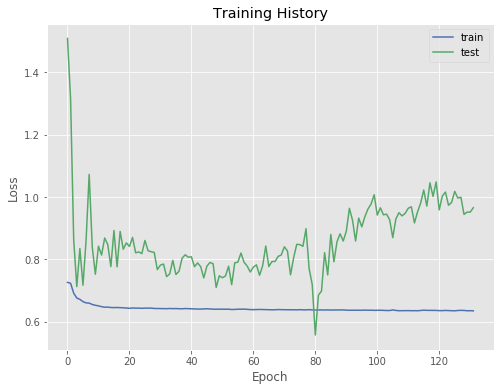

1952/2044 [===========================>..] - ETA: 0s

AUC: 0.5


AUC: 0.76133



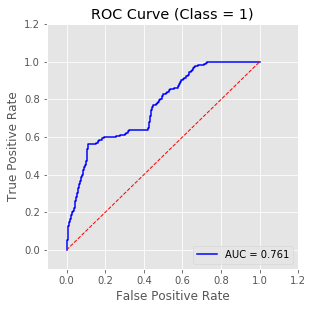

In [29]:
naive_score, fx_features_auc = do_one_model('CAD', feature_col_names =  ['CA_FX', 'CA_BMP_Ratio'])

### All features

In [30]:
cols = [feature_cols[i] for i in range(n_feature_cols) 
        if re.search('CA_FX', feature_cols[i]) == None]
naive_score, fx_all_auc = do_one_model('CAD', feature_col_names = ['CA_FX'] + cols, do_pca = True)

In [31]:
all_results = accum_results(all_results, 'CAD', naive_score, fx_auc, fx_features_auc, fx_all_auc)

## Japan

### FX rates only

In [32]:
naive_score, fx_auc = do_one_model('JPY', feature_col_names = ['JP_FX'], verbose = 2)

Time period: 2000-01-03 - 2017-12-09


JP_FX

Scaled data shape: (6551, 1)
Reframed data shape: (6192, 181)


1984/2044 [============================>.] - ETA: 0s

AUC: 0.5


AUC: 0.57153


### FX rates and other features

Time period: 2000-01-03 - 2017-12-09


JP_FX, JP_BMP_Ratio

Scaled data shape: (6551, 2)
Reframed data shape: (6192, 361)


JP_FX(t-180),JP_BMP_Ratio(t-180),JP_FX(t-179),JP_BMP_Ratio(t-179),JP_FX(t-178),JP_BMP_Ratio(t-178),JP_FX(t-177),JP_BMP_Ratio(t-177),JP_FX(t-176),JP_BMP_Ratio(t-176),JP_FX(t-175),JP_BMP_Ratio(t-175),JP_FX(t-174),JP_BMP_Ratio(t-174),JP_FX(t-173),JP_BMP_Ratio(t-173),JP_FX(t-172),JP_BMP_Ratio(t-172),JP_FX(t-171),JP_BMP_Ratio(t-171),JP_FX(t-170),JP_BMP_Ratio(t-170),JP_FX(t-169),JP_BMP_Ratio(t-169),JP_FX(t-168),JP_BMP_Ratio(t-168),JP_FX(t-167),JP_BMP_Ratio(t-167),JP_FX(t-166),JP_BMP_Ratio(t-166),JP_FX(t-165),JP_BMP_Ratio(t-165),JP_FX(t-164),JP_BMP_Ratio(t-164),JP_FX(t-163),JP_BMP_Ratio(t-163),JP_FX(t-162),JP_BMP_Ratio(t-162),JP_FX(t-161),JP_BMP_Ratio(t-161),JP_FX(t-160),JP_BMP_Ratio(t-160),JP_FX(t-159),JP_BMP_Ratio(t-159),JP_FX(t-158),JP_BMP_Ratio(t-158),JP_FX(t-157),JP_BMP_Ratio(t-157),JP_FX(t-156),JP_BMP_Ratio(t-156),JP_FX(t-155),JP_BMP_Ratio(t-155),JP_FX(t-154),JP_BMP_Ratio(t-154),JP_FX(t-153),JP_BMP_Ratio(t-153),JP_FX(t-152),JP_BMP_Ratio(t-152),JP_FX(t-151),JP_BMP_Ratio(t-151),JP_FX(t-150),JP_BMP_Ratio(t-150),JP_FX(t-149),JP_BMP_Ratio(t-149),JP_FX(t-148),JP_BMP_Ratio(t-148),JP_FX(t-147),JP_BMP_Ratio(t-147),JP_FX(t-146),JP_BMP_Ratio(t-146),JP_FX(t-145),JP_BMP_Ratio(t-145),JP_FX(t-144),JP_BMP_Ratio(t-144),JP_FX(t-143),JP_BMP_Ratio(t-143),JP_FX(t-142),JP_BMP_Ratio(t-142),JP_FX(t-141),JP_BMP_Ratio(t-141),JP_FX(t-140),JP_BMP_Ratio(t-140),JP_FX(t-139),JP_BMP_Ratio(t-139),JP_FX(t-138),JP_BMP_Ratio(t-138),JP_FX(t-137),JP_BMP_Ratio(t-137),JP_FX(t-136),JP_BMP_Ratio(t-136),JP_FX(t-135),JP_BMP_Ratio(t-135),JP_FX(t-134),JP_BMP_Ratio(t-134),JP_FX(t-133),JP_BMP_Ratio(t-133),JP_FX(t-132),JP_BMP_Ratio(t-132),JP_FX(t-131),JP_BMP_Ratio(t-131),JP_FX(t-130),JP_BMP_Ratio(t-130),JP_FX(t-129),JP_BMP_Ratio(t-129),JP_FX(t-128),JP_BMP_Ratio(t-128),JP_FX(t-127),JP_BMP_Ratio(t-127),JP_FX(t-126),JP_BMP_Ratio(t-126),JP_FX(t-125),JP_BMP_Ratio(t-125),JP_FX(t-124),JP_BMP_Ratio(t-124),JP_FX(t-123),JP_BMP_Ratio(t-123),JP_FX(t-122),JP_BMP_Ratio(t-122),JP_FX(t-121),JP_BMP_Ratio(t-121),JP_FX(t-120),JP_BMP_Ratio(t-120),JP_FX(t-119),JP_BMP_Ratio(t-119),JP_FX(t-118),JP_BMP_Ratio(t-118),JP_FX(t-117),JP_BMP_Ratio(t-117),JP_FX(t-116),JP_BMP_Ratio(t-116),JP_FX(t-115),JP_BMP_Ratio(t-115),JP_FX(t-114),JP_BMP_Ratio(t-114),JP_FX(t-113),JP_BMP_Ratio(t-113),JP_FX(t-112),JP_BMP_Ratio(t-112),JP_FX(t-111),JP_BMP_Ratio(t-111),JP_FX(t-110),JP_BMP_Ratio(t-110),JP_FX(t-109),JP_BMP_Ratio(t-109),JP_FX(t-108),JP_BMP_Ratio(t-108),JP_FX(t-107),JP_BMP_Ratio(t-107),JP_FX(t-106),JP_BMP_Ratio(t-106),JP_FX(t-105),JP_BMP_Ratio(t-105),JP_FX(t-104),JP_BMP_Ratio(t-104),JP_FX(t-103),JP_BMP_Ratio(t-103),JP_FX(t-102),JP_BMP_Ratio(t-102),JP_FX(t-101),JP_BMP_Ratio(t-101),JP_FX(t-100),JP_BMP_Ratio(t-100),JP_FX(t-99),JP_BMP_Ratio(t-99),JP_FX(t-98),JP_BMP_Ratio(t-98),JP_FX(t-97),JP_BMP_Ratio(t-97),JP_FX(t-96),JP_BMP_Ratio(t-96),JP_FX(t-95),JP_BMP_Ratio(t-95),JP_FX(t-94),JP_BMP_Ratio(t-94),JP_FX(t-93),JP_BMP_Ratio(t-93),JP_FX(t-92),JP_BMP_Ratio(t-92),JP_FX(t-91),JP_BMP_Ratio(t-91),JP_FX(t-90),JP_BMP_Ratio(t-90),JP_FX(t-89),JP_BMP_Ratio(t-89),JP_FX(t-88),JP_BMP_Ratio(t-88),JP_FX(t-87),JP_BMP_Ratio(t-87),JP_FX(t-86),JP_BMP_Ratio(t-86),JP_FX(t-85),JP_BMP_Ratio(t-85),JP_FX(t-84),JP_BMP_Ratio(t-84),JP_FX(t-83),JP_BMP_Ratio(t-83),JP_FX(t-82),JP_BMP_Ratio(t-82),JP_FX(t-81),JP_BMP_Ratio(t-81),JP_FX(t-80),JP_BMP_Ratio(t-80),JP_FX(t-79),JP_BMP_Ratio(t-79),JP_FX(t-78),JP_BMP_Ratio(t-78),JP_FX(t-77),JP_BMP_Ratio(t-77),JP_FX(t-76),JP_BMP_Ratio(t-76),JP_FX(t-75),JP_BMP_Ratio(t-75),JP_FX(t-74),JP_BMP_Ratio(t-74),JP_FX(t-73),JP_BMP_Ratio(t-73),JP_FX(t-72),JP_BMP_Ratio(t-72),JP_FX(t-71),JP_BMP_Ratio(t-71),JP_FX(t-70),JP_BMP_Ratio(t-70),JP_FX(t-69),JP_BMP_Ratio(t-69),JP_FX(t-68),JP_BMP_Ratio(t-68),JP_FX(t-67),JP_BMP_Ratio(t-67),JP_FX(t-66),JP_BMP_Ratio(t-66),JP_FX(t-65),JP_BMP_Ratio(t-65),JP_FX(t-64),JP_BMP_Ratio(t-64),JP_FX(t-63),JP_BMP_Ratio(t-63),JP_FX(t-62),JP_BMP_Ratio(t-62),JP_FX(t-61),JP_BMP_Ratio(t-61),JP_FX(t-60),JP_BMP_Ratio(t-60),JP_FX(t-59),JP_BMP_Ratio(t-59),JP_FX(t-58),JP_BMP_Ratio(t-58),JP_FX(t-57),JP_BMP_Ratio(

(4148, 360) (4148,) (2044, 360) (2044,)


Train on 4148 samples, validate on 2044 samples
Epoch 1/200
4s - loss: 0.7457 - val_loss: 2.0156
Epoch 2/200
3s - loss: 0.8720 - val_loss: 3.0539
Epoch 3/200
4s - loss: 0.7001 - val_loss: 2.2756
Epoch 4/200
4s - loss: 0.6850 - val_loss: 1.9210
Epoch 5/200
3s - loss: 0.6811 - val_loss: 2.4773
Epoch 6/200
3s - loss: 0.6772 - val_loss: 1.5994
Epoch 7/200
3s - loss: 0.6704 - val_loss: 0.7800
Epoch 8/200
4s - loss: 0.6621 - val_loss: 0.9505
Epoch 9/200
3s - loss: 0.6913 - val_loss: 0.6994
Epoch 10/200
3s - loss: 0.6625 - val_loss: 1.0402
Epoch 11/200
4s - loss: 0.6738 - val_loss: 0.7582
Epoch 12/200
3s - loss: 0.6622 - val_loss: 0.8321
Epoch 13/200
3s - loss: 0.6591 - val_loss: 0.8408
Epoch 14/200
4s - loss: 0.6605 - val_loss: 0.7409
Epoch 15/200
4s - loss: 0.6603 - val_loss: 1.0067
Epoch 16/200
3s - loss: 0.6592 - val_loss: 0.7561
Epoch 17/200
3s - loss: 0.6599 - val_loss: 0.6925
Epoch 18/200
3s - loss: 0.6588 - val_loss: 1.1098
Epoch 19/200
3s - loss: 0.6581 - val_loss: 0.9117
Epoch 20/20

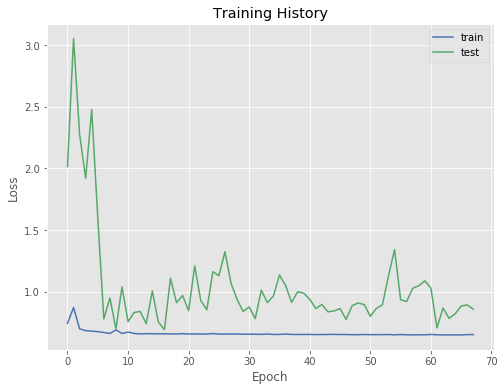

1952/2044 [===========================>..] - ETA: 0s

AUC: 0.5


AUC: 0.30152



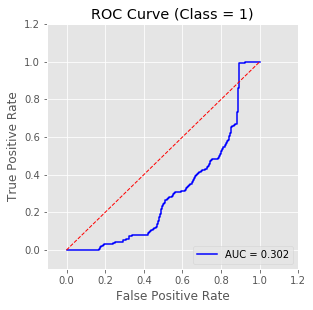

In [33]:
naive_score, fx_features_auc = do_one_model('JPY', feature_col_names = ['JP_FX', 'JP_BMP_Ratio'])

### All features

In [34]:
cols = [feature_cols[i] for i in range(n_feature_cols) 
        if re.search('JP_FX', feature_cols[i]) == None]
naive_score, fx_all_auc = do_one_model('JPY', feature_col_names = ['JP_FX'] + cols, do_pca = True)

In [35]:
all_results = accum_results(all_results, 'JPY', naive_score, fx_auc, fx_features_auc, fx_all_auc)

## Switzerland

### FX rates only

In [36]:
naive_score, fx_auc = do_one_model('CHF', feature_col_names = ['CH_FX'], verbose = 2)

Time period: 2000-01-03 - 2017-12-09


CH_FX

Scaled data shape: (6551, 1)
Reframed data shape: (6192, 181)


1856/2044 [==========================>...] - ETA: 0s

AUC: 0.5


AUC: 0.6445


### FX rates and other features

Time period: 2000-01-03 - 2017-12-09


CH_FX, CH_BMP_Ratio

Scaled data shape: (6551, 2)
Reframed data shape: (6192, 361)


CH_FX(t-180),CH_BMP_Ratio(t-180),CH_FX(t-179),CH_BMP_Ratio(t-179),CH_FX(t-178),CH_BMP_Ratio(t-178),CH_FX(t-177),CH_BMP_Ratio(t-177),CH_FX(t-176),CH_BMP_Ratio(t-176),CH_FX(t-175),CH_BMP_Ratio(t-175),CH_FX(t-174),CH_BMP_Ratio(t-174),CH_FX(t-173),CH_BMP_Ratio(t-173),CH_FX(t-172),CH_BMP_Ratio(t-172),CH_FX(t-171),CH_BMP_Ratio(t-171),CH_FX(t-170),CH_BMP_Ratio(t-170),CH_FX(t-169),CH_BMP_Ratio(t-169),CH_FX(t-168),CH_BMP_Ratio(t-168),CH_FX(t-167),CH_BMP_Ratio(t-167),CH_FX(t-166),CH_BMP_Ratio(t-166),CH_FX(t-165),CH_BMP_Ratio(t-165),CH_FX(t-164),CH_BMP_Ratio(t-164),CH_FX(t-163),CH_BMP_Ratio(t-163),CH_FX(t-162),CH_BMP_Ratio(t-162),CH_FX(t-161),CH_BMP_Ratio(t-161),CH_FX(t-160),CH_BMP_Ratio(t-160),CH_FX(t-159),CH_BMP_Ratio(t-159),CH_FX(t-158),CH_BMP_Ratio(t-158),CH_FX(t-157),CH_BMP_Ratio(t-157),CH_FX(t-156),CH_BMP_Ratio(t-156),CH_FX(t-155),CH_BMP_Ratio(t-155),CH_FX(t-154),CH_BMP_Ratio(t-154),CH_FX(t-153),CH_BMP_Ratio(t-153),CH_FX(t-152),CH_BMP_Ratio(t-152),CH_FX(t-151),CH_BMP_Ratio(t-151),CH_FX(t-150),CH_BMP_Ratio(t-150),CH_FX(t-149),CH_BMP_Ratio(t-149),CH_FX(t-148),CH_BMP_Ratio(t-148),CH_FX(t-147),CH_BMP_Ratio(t-147),CH_FX(t-146),CH_BMP_Ratio(t-146),CH_FX(t-145),CH_BMP_Ratio(t-145),CH_FX(t-144),CH_BMP_Ratio(t-144),CH_FX(t-143),CH_BMP_Ratio(t-143),CH_FX(t-142),CH_BMP_Ratio(t-142),CH_FX(t-141),CH_BMP_Ratio(t-141),CH_FX(t-140),CH_BMP_Ratio(t-140),CH_FX(t-139),CH_BMP_Ratio(t-139),CH_FX(t-138),CH_BMP_Ratio(t-138),CH_FX(t-137),CH_BMP_Ratio(t-137),CH_FX(t-136),CH_BMP_Ratio(t-136),CH_FX(t-135),CH_BMP_Ratio(t-135),CH_FX(t-134),CH_BMP_Ratio(t-134),CH_FX(t-133),CH_BMP_Ratio(t-133),CH_FX(t-132),CH_BMP_Ratio(t-132),CH_FX(t-131),CH_BMP_Ratio(t-131),CH_FX(t-130),CH_BMP_Ratio(t-130),CH_FX(t-129),CH_BMP_Ratio(t-129),CH_FX(t-128),CH_BMP_Ratio(t-128),CH_FX(t-127),CH_BMP_Ratio(t-127),CH_FX(t-126),CH_BMP_Ratio(t-126),CH_FX(t-125),CH_BMP_Ratio(t-125),CH_FX(t-124),CH_BMP_Ratio(t-124),CH_FX(t-123),CH_BMP_Ratio(t-123),CH_FX(t-122),CH_BMP_Ratio(t-122),CH_FX(t-121),CH_BMP_Ratio(t-121),CH_FX(t-120),CH_BMP_Ratio(t-120),CH_FX(t-119),CH_BMP_Ratio(t-119),CH_FX(t-118),CH_BMP_Ratio(t-118),CH_FX(t-117),CH_BMP_Ratio(t-117),CH_FX(t-116),CH_BMP_Ratio(t-116),CH_FX(t-115),CH_BMP_Ratio(t-115),CH_FX(t-114),CH_BMP_Ratio(t-114),CH_FX(t-113),CH_BMP_Ratio(t-113),CH_FX(t-112),CH_BMP_Ratio(t-112),CH_FX(t-111),CH_BMP_Ratio(t-111),CH_FX(t-110),CH_BMP_Ratio(t-110),CH_FX(t-109),CH_BMP_Ratio(t-109),CH_FX(t-108),CH_BMP_Ratio(t-108),CH_FX(t-107),CH_BMP_Ratio(t-107),CH_FX(t-106),CH_BMP_Ratio(t-106),CH_FX(t-105),CH_BMP_Ratio(t-105),CH_FX(t-104),CH_BMP_Ratio(t-104),CH_FX(t-103),CH_BMP_Ratio(t-103),CH_FX(t-102),CH_BMP_Ratio(t-102),CH_FX(t-101),CH_BMP_Ratio(t-101),CH_FX(t-100),CH_BMP_Ratio(t-100),CH_FX(t-99),CH_BMP_Ratio(t-99),CH_FX(t-98),CH_BMP_Ratio(t-98),CH_FX(t-97),CH_BMP_Ratio(t-97),CH_FX(t-96),CH_BMP_Ratio(t-96),CH_FX(t-95),CH_BMP_Ratio(t-95),CH_FX(t-94),CH_BMP_Ratio(t-94),CH_FX(t-93),CH_BMP_Ratio(t-93),CH_FX(t-92),CH_BMP_Ratio(t-92),CH_FX(t-91),CH_BMP_Ratio(t-91),CH_FX(t-90),CH_BMP_Ratio(t-90),CH_FX(t-89),CH_BMP_Ratio(t-89),CH_FX(t-88),CH_BMP_Ratio(t-88),CH_FX(t-87),CH_BMP_Ratio(t-87),CH_FX(t-86),CH_BMP_Ratio(t-86),CH_FX(t-85),CH_BMP_Ratio(t-85),CH_FX(t-84),CH_BMP_Ratio(t-84),CH_FX(t-83),CH_BMP_Ratio(t-83),CH_FX(t-82),CH_BMP_Ratio(t-82),CH_FX(t-81),CH_BMP_Ratio(t-81),CH_FX(t-80),CH_BMP_Ratio(t-80),CH_FX(t-79),CH_BMP_Ratio(t-79),CH_FX(t-78),CH_BMP_Ratio(t-78),CH_FX(t-77),CH_BMP_Ratio(t-77),CH_FX(t-76),CH_BMP_Ratio(t-76),CH_FX(t-75),CH_BMP_Ratio(t-75),CH_FX(t-74),CH_BMP_Ratio(t-74),CH_FX(t-73),CH_BMP_Ratio(t-73),CH_FX(t-72),CH_BMP_Ratio(t-72),CH_FX(t-71),CH_BMP_Ratio(t-71),CH_FX(t-70),CH_BMP_Ratio(t-70),CH_FX(t-69),CH_BMP_Ratio(t-69),CH_FX(t-68),CH_BMP_Ratio(t-68),CH_FX(t-67),CH_BMP_Ratio(t-67),CH_FX(t-66),CH_BMP_Ratio(t-66),CH_FX(t-65),CH_BMP_Ratio(t-65),CH_FX(t-64),CH_BMP_Ratio(t-64),CH_FX(t-63),CH_BMP_Ratio(t-63),CH_FX(t-62),CH_BMP_Ratio(t-62),CH_FX(t-61),CH_BMP_Ratio(t-61),CH_FX(t-60),CH_BMP_Ratio(t-60),CH_FX(t-59),CH_BMP_Ratio(t-59),CH_FX(t-58),CH_BMP_Ratio(t-58),CH_FX(t-57),CH_BMP_Ratio(

(4148, 360) (4148,) (2044, 360) (2044,)


Train on 4148 samples, validate on 2044 samples
Epoch 1/200
5s - loss: 0.7412 - val_loss: 1.7416
Epoch 2/200
4s - loss: 0.6129 - val_loss: 1.3655
Epoch 3/200
4s - loss: 0.5909 - val_loss: 0.6609
Epoch 4/200
4s - loss: 0.5830 - val_loss: 0.7886
Epoch 5/200
4s - loss: 0.5788 - val_loss: 0.6621
Epoch 6/200
4s - loss: 0.5740 - val_loss: 0.7580
Epoch 7/200
4s - loss: 0.5703 - val_loss: 0.7146
Epoch 8/200
4s - loss: 0.5690 - val_loss: 0.7006
Epoch 9/200
4s - loss: 0.5665 - val_loss: 0.7181
Epoch 10/200
3s - loss: 0.5655 - val_loss: 0.6922
Epoch 11/200
3s - loss: 0.5637 - val_loss: 0.6678
Epoch 12/200
3s - loss: 0.5622 - val_loss: 0.6709
Epoch 13/200
3s - loss: 0.5613 - val_loss: 0.7487
Epoch 14/200
3s - loss: 0.5611 - val_loss: 0.6865
Epoch 15/200
4s - loss: 0.5595 - val_loss: 0.6574
Epoch 16/200
3s - loss: 0.5593 - val_loss: 0.6563
Epoch 17/200
3s - loss: 0.5578 - val_loss: 0.6555
Epoch 18/200
3s - loss: 0.5577 - val_loss: 0.7277
Epoch 19/200
3s - loss: 0.5570 - val_loss: 0.6982
Epoch 20/20

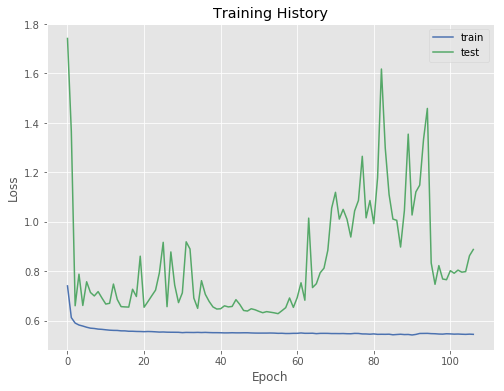

1888/2044 [==========================>...] - ETA: 0s

AUC: 0.5


AUC: 0.74585



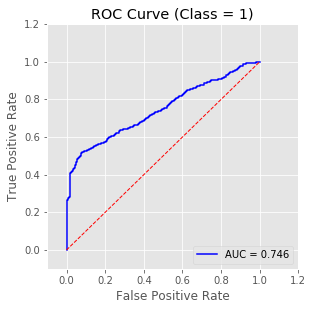

In [37]:
naive_score, fx_features_auc = do_one_model('CHF', feature_col_names = ['CH_FX', 'CH_BMP_Ratio'])

### All features

In [38]:
cols = [feature_cols[i] for i in range(n_feature_cols) 
        if re.search('CH_FX', feature_cols[i]) == None]
naive_score, fx_all_auc = do_one_model('CHF', feature_col_names = ['CH_FX'] + cols, do_pca = True)

In [39]:
all_results = accum_results(all_results, 'CHF', naive_score, fx_auc, fx_features_auc, fx_all_auc)

## UK

### FX rates only

In [40]:
naive_score, fx_auc = do_one_model('GBP', feature_col_names = ['UK_FX'], verbose = 2)

Time period: 2000-01-03 - 2017-12-09


UK_FX

Scaled data shape: (6551, 1)
Reframed data shape: (6192, 181)


1696/2044 [=======================>......] - ETA: 0s

AUC: 0.5


AUC: 0.71361


### FX rates and other features

Time period: 2000-01-03 - 2017-12-09


UK_FX, UK_BMP_Ratio

Scaled data shape: (6551, 2)
Reframed data shape: (6192, 361)


UK_FX(t-180),UK_BMP_Ratio(t-180),UK_FX(t-179),UK_BMP_Ratio(t-179),UK_FX(t-178),UK_BMP_Ratio(t-178),UK_FX(t-177),UK_BMP_Ratio(t-177),UK_FX(t-176),UK_BMP_Ratio(t-176),UK_FX(t-175),UK_BMP_Ratio(t-175),UK_FX(t-174),UK_BMP_Ratio(t-174),UK_FX(t-173),UK_BMP_Ratio(t-173),UK_FX(t-172),UK_BMP_Ratio(t-172),UK_FX(t-171),UK_BMP_Ratio(t-171),UK_FX(t-170),UK_BMP_Ratio(t-170),UK_FX(t-169),UK_BMP_Ratio(t-169),UK_FX(t-168),UK_BMP_Ratio(t-168),UK_FX(t-167),UK_BMP_Ratio(t-167),UK_FX(t-166),UK_BMP_Ratio(t-166),UK_FX(t-165),UK_BMP_Ratio(t-165),UK_FX(t-164),UK_BMP_Ratio(t-164),UK_FX(t-163),UK_BMP_Ratio(t-163),UK_FX(t-162),UK_BMP_Ratio(t-162),UK_FX(t-161),UK_BMP_Ratio(t-161),UK_FX(t-160),UK_BMP_Ratio(t-160),UK_FX(t-159),UK_BMP_Ratio(t-159),UK_FX(t-158),UK_BMP_Ratio(t-158),UK_FX(t-157),UK_BMP_Ratio(t-157),UK_FX(t-156),UK_BMP_Ratio(t-156),UK_FX(t-155),UK_BMP_Ratio(t-155),UK_FX(t-154),UK_BMP_Ratio(t-154),UK_FX(t-153),UK_BMP_Ratio(t-153),UK_FX(t-152),UK_BMP_Ratio(t-152),UK_FX(t-151),UK_BMP_Ratio(t-151),UK_FX(t-150),UK_BMP_Ratio(t-150),UK_FX(t-149),UK_BMP_Ratio(t-149),UK_FX(t-148),UK_BMP_Ratio(t-148),UK_FX(t-147),UK_BMP_Ratio(t-147),UK_FX(t-146),UK_BMP_Ratio(t-146),UK_FX(t-145),UK_BMP_Ratio(t-145),UK_FX(t-144),UK_BMP_Ratio(t-144),UK_FX(t-143),UK_BMP_Ratio(t-143),UK_FX(t-142),UK_BMP_Ratio(t-142),UK_FX(t-141),UK_BMP_Ratio(t-141),UK_FX(t-140),UK_BMP_Ratio(t-140),UK_FX(t-139),UK_BMP_Ratio(t-139),UK_FX(t-138),UK_BMP_Ratio(t-138),UK_FX(t-137),UK_BMP_Ratio(t-137),UK_FX(t-136),UK_BMP_Ratio(t-136),UK_FX(t-135),UK_BMP_Ratio(t-135),UK_FX(t-134),UK_BMP_Ratio(t-134),UK_FX(t-133),UK_BMP_Ratio(t-133),UK_FX(t-132),UK_BMP_Ratio(t-132),UK_FX(t-131),UK_BMP_Ratio(t-131),UK_FX(t-130),UK_BMP_Ratio(t-130),UK_FX(t-129),UK_BMP_Ratio(t-129),UK_FX(t-128),UK_BMP_Ratio(t-128),UK_FX(t-127),UK_BMP_Ratio(t-127),UK_FX(t-126),UK_BMP_Ratio(t-126),UK_FX(t-125),UK_BMP_Ratio(t-125),UK_FX(t-124),UK_BMP_Ratio(t-124),UK_FX(t-123),UK_BMP_Ratio(t-123),UK_FX(t-122),UK_BMP_Ratio(t-122),UK_FX(t-121),UK_BMP_Ratio(t-121),UK_FX(t-120),UK_BMP_Ratio(t-120),UK_FX(t-119),UK_BMP_Ratio(t-119),UK_FX(t-118),UK_BMP_Ratio(t-118),UK_FX(t-117),UK_BMP_Ratio(t-117),UK_FX(t-116),UK_BMP_Ratio(t-116),UK_FX(t-115),UK_BMP_Ratio(t-115),UK_FX(t-114),UK_BMP_Ratio(t-114),UK_FX(t-113),UK_BMP_Ratio(t-113),UK_FX(t-112),UK_BMP_Ratio(t-112),UK_FX(t-111),UK_BMP_Ratio(t-111),UK_FX(t-110),UK_BMP_Ratio(t-110),UK_FX(t-109),UK_BMP_Ratio(t-109),UK_FX(t-108),UK_BMP_Ratio(t-108),UK_FX(t-107),UK_BMP_Ratio(t-107),UK_FX(t-106),UK_BMP_Ratio(t-106),UK_FX(t-105),UK_BMP_Ratio(t-105),UK_FX(t-104),UK_BMP_Ratio(t-104),UK_FX(t-103),UK_BMP_Ratio(t-103),UK_FX(t-102),UK_BMP_Ratio(t-102),UK_FX(t-101),UK_BMP_Ratio(t-101),UK_FX(t-100),UK_BMP_Ratio(t-100),UK_FX(t-99),UK_BMP_Ratio(t-99),UK_FX(t-98),UK_BMP_Ratio(t-98),UK_FX(t-97),UK_BMP_Ratio(t-97),UK_FX(t-96),UK_BMP_Ratio(t-96),UK_FX(t-95),UK_BMP_Ratio(t-95),UK_FX(t-94),UK_BMP_Ratio(t-94),UK_FX(t-93),UK_BMP_Ratio(t-93),UK_FX(t-92),UK_BMP_Ratio(t-92),UK_FX(t-91),UK_BMP_Ratio(t-91),UK_FX(t-90),UK_BMP_Ratio(t-90),UK_FX(t-89),UK_BMP_Ratio(t-89),UK_FX(t-88),UK_BMP_Ratio(t-88),UK_FX(t-87),UK_BMP_Ratio(t-87),UK_FX(t-86),UK_BMP_Ratio(t-86),UK_FX(t-85),UK_BMP_Ratio(t-85),UK_FX(t-84),UK_BMP_Ratio(t-84),UK_FX(t-83),UK_BMP_Ratio(t-83),UK_FX(t-82),UK_BMP_Ratio(t-82),UK_FX(t-81),UK_BMP_Ratio(t-81),UK_FX(t-80),UK_BMP_Ratio(t-80),UK_FX(t-79),UK_BMP_Ratio(t-79),UK_FX(t-78),UK_BMP_Ratio(t-78),UK_FX(t-77),UK_BMP_Ratio(t-77),UK_FX(t-76),UK_BMP_Ratio(t-76),UK_FX(t-75),UK_BMP_Ratio(t-75),UK_FX(t-74),UK_BMP_Ratio(t-74),UK_FX(t-73),UK_BMP_Ratio(t-73),UK_FX(t-72),UK_BMP_Ratio(t-72),UK_FX(t-71),UK_BMP_Ratio(t-71),UK_FX(t-70),UK_BMP_Ratio(t-70),UK_FX(t-69),UK_BMP_Ratio(t-69),UK_FX(t-68),UK_BMP_Ratio(t-68),UK_FX(t-67),UK_BMP_Ratio(t-67),UK_FX(t-66),UK_BMP_Ratio(t-66),UK_FX(t-65),UK_BMP_Ratio(t-65),UK_FX(t-64),UK_BMP_Ratio(t-64),UK_FX(t-63),UK_BMP_Ratio(t-63),UK_FX(t-62),UK_BMP_Ratio(t-62),UK_FX(t-61),UK_BMP_Ratio(t-61),UK_FX(t-60),UK_BMP_Ratio(t-60),UK_FX(t-59),UK_BMP_Ratio(t-59),UK_FX(t-58),UK_BMP_Ratio(t-58),UK_FX(t-57),UK_BMP_Ratio(

(4148, 360) (4148,) (2044, 360) (2044,)


Train on 4148 samples, validate on 2044 samples
Epoch 1/200
4s - loss: 0.8190 - val_loss: 1.0150
Epoch 2/200
3s - loss: 0.7332 - val_loss: 0.7604
Epoch 3/200
3s - loss: 0.7122 - val_loss: 0.7132
Epoch 4/200
4s - loss: 0.7054 - val_loss: 0.7898
Epoch 5/200
3s - loss: 0.7011 - val_loss: 0.8603
Epoch 6/200
3s - loss: 0.7017 - val_loss: 1.0517
Epoch 7/200
4s - loss: 0.6954 - val_loss: 0.7881
Epoch 8/200
4s - loss: 0.6919 - val_loss: 1.0579
Epoch 9/200
4s - loss: 0.6925 - val_loss: 0.8159
Epoch 10/200
3s - loss: 0.6916 - val_loss: 0.8004
Epoch 11/200
3s - loss: 0.6913 - val_loss: 1.6758
Epoch 12/200
3s - loss: 0.6908 - val_loss: 0.8103
Epoch 13/200
3s - loss: 0.6886 - val_loss: 0.7842
Epoch 14/200
3s - loss: 0.6895 - val_loss: 0.9978
Epoch 15/200
3s - loss: 0.6890 - val_loss: 1.0897
Epoch 16/200
3s - loss: 0.6897 - val_loss: 1.2026
Epoch 17/200
3s - loss: 0.6860 - val_loss: 1.2802
Epoch 18/200
3s - loss: 0.6864 - val_loss: 1.0529
Epoch 19/200
3s - loss: 0.6861 - val_loss: 0.8442
Epoch 20/20

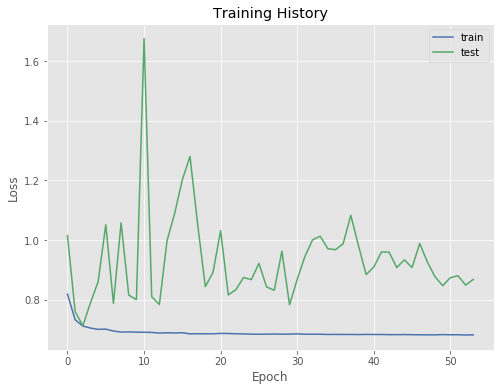

2044/2044 [==============================] - 0s     


AUC: 0.5


AUC: 0.4882



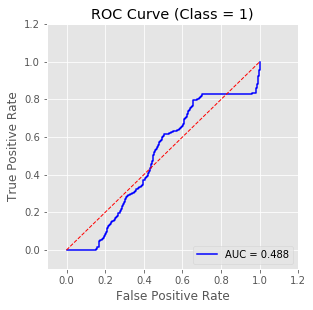

In [41]:
naive_score, fx_features_auc = do_one_model('GBP', feature_col_names = ['UK_FX', 'UK_BMP_Ratio'])

### All features

In [42]:
cols = [feature_cols[i] for i in range(n_feature_cols) 
        if re.search('UK_FX', feature_cols[i]) == None]
naive_score, fx_all_auc = do_one_model('GBP', feature_col_names = ['UK_FX'] + cols, do_pca = True)

In [43]:
all_results = accum_results(all_results, 'GBP', naive_score, fx_auc, fx_features_auc, fx_all_auc)

# Summary of results

#### Test AUC for all FX rates (relative to USD)

In [44]:
all_results = all_results[['Currency', 'Naive', 'FX Only', 'FX + Features', 'All Features']]
all_results.to_csv('AUC_FFNN_7.csv', index = False)

pd.options.display.float_format = '{:,.5f}'.format
my_linespace()
my_display_df(all_results)

Currency,Naive,FX Only,FX + Features,All Features
AUD,None,0.77536,0.75786,None
CAD,None,0.43917,0.76133,None
JPY,None,0.57153,0.30152,None
CHF,None,0.64450,0.74585,None
GBP,None,0.71361,0.48820,None


#### Visualize test AUC

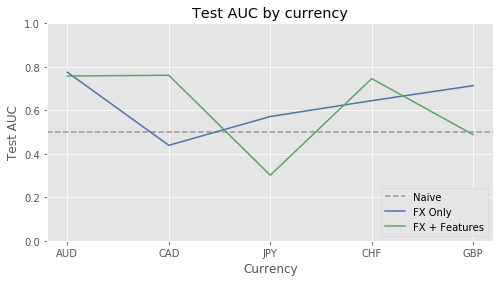

In [45]:
n_items = all_results.shape[0]

print()
fig, ax = plt.subplots(figsize = (8, 4))

ax.axhline(y = 0.5, color = '0.6', linestyle = '--', label = 'Naive')

ax.plot(range(n_items), all_results['FX Only'], label = 'FX Only')
ax.plot(range(n_items), all_results['FX + Features'], label = 'FX + Features')
#ax.plot(range(n_items), all_results['All Features'], label = 'All Features')

ax.set_ylim((0.0, 1.0))
ax.set_xticks(range(n_items))
ax.set_xticklabels(all_results['Currency'])

ax.set_xlabel('Currency')
ax.set_ylabel('Test AUC')
ax.set_title('Test AUC by currency')

plt.legend(loc = 'lower right')
plt.show()

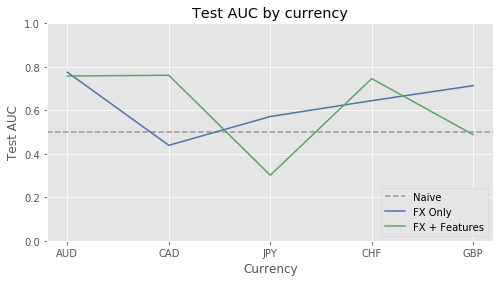

In [46]:
n_items = all_results.shape[0]

print()
fig, ax = plt.subplots(figsize = (8, 4))

ax.axhline(y = 0.5, color = '0.6', linestyle = '--', label = 'Naive')

ax.plot(range(n_items), all_results['FX Only'], label = 'FX Only')
ax.plot(range(n_items), all_results['FX + Features'], label = 'FX + Features')
#ax.plot(range(n_items), all_results['All Features'], label = 'All Features')

ax.set_ylim((0.0, 1.0))
ax.set_xticks(range(n_items))
ax.set_xticklabels(all_results['Currency'])

ax.set_xlabel('Currency')
ax.set_ylabel('Test AUC')
ax.set_title('Test AUC by currency')

plt.legend(loc = 'lower right')
plt.show()